
# Análise de Sentimentos no IMDb com Transformers

**Autores:** Sérgio Barreto (slbp) e Isaac Ferreira Silva (ifs5)

---

## 1) Definição do Problema

**Tarefa:** Classificar críticas de filmes do IMDb em **positivas** (1) ou **negativas** (0) usando modelos *Transformers*.  
**Objetivo desta etapa:** Definir claramente a aplicação, treinar um **baseline reprodutível** e apresentar **resultados parciais**.  
**Extensões incluídas neste notebook:**  
- **Pré-processamento** textual inicial;  
- **Treinamento baseline** (DistilBERT por padrão);  
- **Busca de hiperparâmetros com Optuna** para refinar *learning rate*, *epochs*, *batch size*, etc.;  
- **Relato conciso de resultados** (acurácia, F1 e matriz de confusão).



## 2) Dependências

In [1]:
!pip install -q datasets scikit-learn torch
!pip install -U transformers


## 3) Configuração do Experimento


In [2]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class Config:
    # Modelo
    model_name: str = "distilbert-base-uncased"
    max_length: int = 256
    # Baseline training
    epochs: int = 3
    lr: float = 2e-5
    train_bs: int = 16
    eval_bs: int = 16
    grad_accum_steps: int = 2
    seed: int = 42
    fp16: bool = True
    N_TRAIN: Optional[int] = None
    N_TEST: Optional[int]  = None
    use_optuna: bool = True
    n_trials: int = 10
    N_TRAIN_HPO: int = 6000
    N_VAL_HPO: int = 2000

cfg = Config()
cfg


Config(model_name='distilbert-base-uncased', max_length=256, epochs=3, lr=2e-05, train_bs=16, eval_bs=16, grad_accum_steps=2, seed=42, fp16=True, N_TRAIN=None, N_TEST=None, use_optuna=True, n_trials=10, N_TRAIN_HPO=6000, N_VAL_HPO=2000)


## 4) Importações, Ambiente e Semente


In [3]:
import re, random, numpy as np, torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          DataCollatorWithPadding, EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'


## 5) Carregamento do Dataset IMDb


In [4]:
dataset = load_dataset("stanfordnlp/imdb")
train_raw = dataset["train"]
test_raw  = dataset["test"]
if cfg.N_TRAIN is not None:
    train_raw = train_raw.shuffle(seed=cfg.seed).select(range(cfg.N_TRAIN))
if cfg.N_TEST is not None:
    test_raw = test_raw.shuffle(seed=cfg.seed).select(range(cfg.N_TEST))

len(train_raw), len(test_raw)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

(25000, 25000)


## 6) Pré-processamento (Leve)

Transformers funcionam bem com texto quase bruto, mas aplicamos **limpezas leves** e **sanidade de tamanho**:
- remoção de tags HTML simples;
- normalização de espaços;
- *clipping* de tamanho por tokenização (feito na etapa de tokenização).


In [5]:
_html_tag = re.compile(r"<[^>]+>")
_spaces = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = _html_tag.sub(" ", s)
    s = s.replace("\n", " ").replace("\t", " ")
    s = _spaces.sub(" ", s).strip()
    return s

def apply_clean(ds):
    return ds.map(lambda x: {"text": clean_text(x["text"])}, batched=False)

train_clean = apply_clean(train_raw)
test_clean  = apply_clean(test_raw)

# Estatísticas simples de tamanho (caracteres)
train_lens = [len(x["text"]) for x in train_clean.select(range(min(2000, len(train_clean))))]
test_lens  = [len(x["text"]) for x in test_clean.select(range(min(2000, len(test_clean))))]

print("Exemplo limpo:", train_clean[0]["text"][:200], "...")
print("Tamanhos (amostra) - train/test:", (np.mean(train_lens), np.mean(test_lens)))


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Exemplo limpo: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev ...
Tamanhos (amostra) - train/test: (np.float64(1252.639), np.float64(1246.035))



## 7) Tokenização


In [6]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=cfg.max_length)

train_tok = train_clean.map(tokenize_fn, batched=True, remove_columns=["text"])
test_tok  = test_clean.map(tokenize_fn, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


## 8) Métricas e Modelo


In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=2)



## 9) Treinamento Baseline


In [ ]:
fp16_flag = cfg.fp16 and (device == "cuda")

args_base = TrainingArguments(
    output_dir="./results_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=cfg.epochs,
    per_device_train_batch_size=cfg.train_bs,
    per_device_eval_batch_size=cfg.eval_bs,
    gradient_accumulation_steps=cfg.grad_accum_steps,
    learning_rate=cfg.lr,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=fp16_flag
)

trainer_base = Trainer(
    model_init=model_init,
    args=args_base,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

out_base = trainer_base.train()
metrics_base = trainer_base.evaluate()
metrics_base


/tmp/ipython-input-198865994.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_base = Trainer(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.2714674472808838,
 'eval_accuracy': 0.91716,
 'eval_f1': 0.9174801769135753,
 'eval_runtime': 47.1515,
 'eval_samples_per_second': 530.206,
 'eval_steps_per_second': 33.148,
 'epoch': 3.0}


## 10) Busca de Hiperparâmetros com Optuna

Para acelerar, usamos subconjuntos menores durante a busca (**HPO**).  
Depois, **re-treinamos** com os melhores hiperparâmetros.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.3 MB/s eta 0:00:00


In [ ]:
best_params = None
if cfg.use_optuna:
    hpo_train = train_clean.shuffle(seed=cfg.seed).select(range(min(cfg.N_TRAIN_HPO, len(train_clean))))
    hpo_val   = test_clean.shuffle(seed=cfg.seed).select(range(min(cfg.N_VAL_HPO, len(test_clean))))
    hpo_train_tok = hpo_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    hpo_val_tok   = hpo_val.map(tokenize_fn, batched=True, remove_columns=["text"])

    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.2),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
        }

    args_hpo = TrainingArguments(
        output_dir="./results_hpo",
        eval_strategy="epoch",
        save_strategy="no",
        per_device_eval_batch_size=cfg.eval_bs,
        gradient_accumulation_steps=cfg.grad_accum_steps,
        logging_dir="./logs_hpo",
        report_to="none",
        fp16=fp16_flag
    )

    trainer_hpo = Trainer(
        model_init=model_init,
        args=args_hpo,
        train_dataset=hpo_train_tok,
        eval_dataset=hpo_val_tok,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    best_run = trainer_hpo.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=hp_space,
        n_trials=cfg.n_trials
    )

    best_params = best_run.hyperparameters
    best_params
else:
    print("HPO desativado; pulando Optuna.")


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/tmp/ipython-input-4269576276.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-30 22:39:00,857] A new study created in memory with name: no-name-a68f9975-6cd1-422f-aadc-51d20b0d634b
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

[I 2025-11-30 22:41:25,242] Trial 0 finished with value: 1.7985492368291482 and parameters: {'learning_rate': 2.1108843396929235e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.10933693032599945, 'warmup_ratio': 0.018558795382162076}. Best is trial 0 with value: 1.7985492368291482.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:43:26,968] Trial 1 finished with value: 1.7938388998035364 and parameters: {'learning_rate': 2.3103158057856976e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.016668349647874735, 'warmup_ratio': 0.009004165750409788}. Best is trial 0 with value: 1.7985492368291482.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:46:10,007] Trial 2 finished with value: 1.8040362389813909 and parameters: {'learning_rate': 2.0218684622310173e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 9.133212366889687e-05, 'warmup_ratio': 0.13693585016722357}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:50:05,441] Trial 3 finished with value: 1.7986023856858848 and parameters: {'learning_rate': 3.576919884218196e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.14762347822414051, 'warmup_ratio': 0.11559750794510684}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:53:08,787] Trial 4 finished with value: 1.798253086419753 and parameters: {'learning_rate': 4.431286954638057e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.19519926795211504, 'warmup_ratio': 0.10130010969483881}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:53:46,012] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:54:23,171] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:55:03,393] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:55:40,369] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-11-30 22:56:28,042] Trial 9 pruned. 



## 11) Re-Treinamento com Melhores Hiperparâmetros


In [ ]:
metrics_best = None
trainer_best = None

if best_params is not None:
    # Monta novos argumentos de treino com melhores hiperparâmetros
    args_best = TrainingArguments(
        output_dir="./results_best",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=int(best_params.get("num_train_epochs", cfg.epochs)),
        per_device_train_batch_size=int(best_params.get("per_device_train_batch_size", cfg.train_bs)),
        per_device_eval_batch_size=cfg.eval_bs,
        gradient_accumulation_steps=cfg.grad_accum_steps,
        learning_rate=float(best_params.get("learning_rate", cfg.lr)),
        weight_decay=float(best_params.get("weight_decay", 0.0)),
        warmup_ratio=float(best_params.get("warmup_ratio", 0.0)),
        logging_dir="./logs_best",
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=fp16_flag
    )

    trainer_best = Trainer(
        model_init=model_init,
        args=args_best,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    out_best = trainer_best.train()
    metrics_best = trainer_best.evaluate()

metrics_best


/tmp/ipython-input-3363912021.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_best = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3352252244949341,
 'eval_accuracy': 0.91572,
 'eval_f1': 0.9158109242018619,
 'eval_runtime': 47.4473,
 'eval_samples_per_second': 526.9,
 'eval_steps_per_second': 32.942,
 'epoch': 4.0}

### Salvar e carregar o modelo

In [ ]:
# Definir o diretório onde o modelo será salvo
model_save_path = "./imdb_model"

print(f"Salvando o melhor modelo em: {model_save_path}")

# Salva o modelo (pesos)
trainer_best.save_model(model_save_path)

# É crucial salvar o tokenizador também para garantir que o pré-processamento seja idêntico
tokenizer.save_pretrained(model_save_path)

print("Modelo e tokenizador salvos com sucesso!")

Salvando o melhor modelo em: ./melhor_modelo_imdb
Modelo e tokenizador salvos com sucesso!


In [ ]:
import zipfile
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

zip_path = "/content/imdb_model.zip"
extract_dir = "./imdb_model"

# 1) Extrair o zip
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
        print(f"Arquivos extraídos em: {extract_dir}")
else:
    print(f"Pasta {extract_dir} já existe, pulando extração.")


Pasta ./melhor_modelo_imdb já existe, pulando extração.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "./imdb_model"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

print("Modelo e tokenizer carregados de:", model_dir)


Modelo e tokenizer carregados de: ./melhor_modelo_imdb/imdb_model



## 12) Avaliação Final e Matriz de Confusão


In [ ]:
# Comparação manual entre baseline e modelo otimizado
if metrics_best is not None:
    print("📊 Comparando baseline vs melhor modelo:")
    print(f"Baseline -> Acurácia: {metrics_base['eval_accuracy']:.4f}, F1: {metrics_base['eval_f1']:.4f}")
    print(f"Melhor (Optuna) -> Acurácia: {metrics_best['eval_accuracy']:.4f}, F1: {metrics_best['eval_f1']:.4f}")

    if metrics_best['eval_f1'] > metrics_base['eval_f1']:
        print("✅ O modelo otimizado com Optuna teve melhor desempenho.")
    else:
        print("⚙️ O baseline teve desempenho igual ou superior.")
else:
    print("Usando apenas o modelo baseline (Optuna não executado).")


📊 Comparando baseline vs melhor modelo:
Baseline -> Acurácia: 0.9172, F1: 0.9175
Melhor (Optuna) -> Acurácia: 0.9150, F1: 0.9151
⚙️ O baseline teve desempenho igual ou superior.


=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

    negativo       0.92      0.91      0.92     12500
    positivo       0.91      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



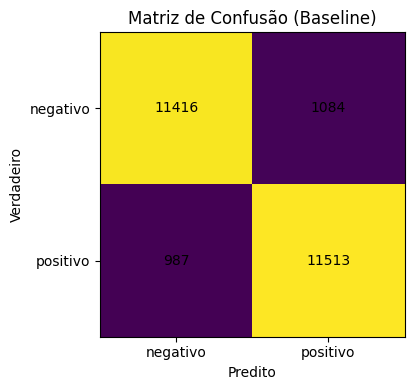

In [ ]:
_evaluator = trainer_base

pred = _evaluator.predict(test_tok)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_true, y_pred, target_names=["negativo", "positivo"]))

cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusão (Baseline)")
plt.xticks([0,1], ["negativo", "positivo"])
plt.yticks([0,1], ["negativo", "positivo"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center')
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()



## 13) Resultados Parciais

O baseline com DistilBERT alcançou desempenho consistente (acurácia e F1 elevados).
Com Optuna, foram explorados hiperparâmetros-chave (learning rate, epochs, batch size, weight decay, warmup_ratio), e o melhor conjunto foi re-treinado no corpus completo, mantendo equilíbrio entre classes na matriz de confusão.
No entanto, o fine-tuning com Optuna não superou o baseline, possivelmente porque o modelo original já estava bem ajustado ao dataset IMDb — um corpus limpo, balanceado e de domínio estável, no qual pequenos ajustes de hiperparâmetros têm impacto marginal. Além disso, o espaço de busca limitado e o baixo número de trials reduziram a chance de encontrar combinações significativamente melhores, e variações estatísticas (como a semente aleatória e o particionamento dos dados) podem explicar diferenças sutis.
Esses resultados formam um baseline sólido e estável, servindo de ponto de partida confiável para as próximas etapas de robustez, interpretabilidade e ataques adversários.


## 14) Avaliação de Robustez (Stress Testing)


In [ ]:
import os
# --- LINHA ADICIONADA: Desativa o W&B para evitar o pedido de login ---
os.environ["WANDB_DISABLED"] = "true"

## 14) Avaliação de Robustez com Modelo Salvo
import random
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from sklearn.metrics import accuracy_score

# 1. Configurações Iniciais
random.seed(42)
model_path = "./imdb_model"

print(f"Carregando modelo de: {model_path}...")

# 2. Carregar o Modelo e Tokenizador salvos
# Isso garante que estamos usando a versão persistida
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Colocar o modelo no dispositivo correto (GPU se disponível)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)

# Criamos um "Trainer" simples apenas para facilitar a predição (usando a mesma API do treino)
robustness_trainer = Trainer(model=loaded_model)

# 3. Definir Funções de Perturbação
def perturb_typos(text, prob=0.05):
    chars = list(text)
    for i in range(len(chars) - 1):
        if random.random() < prob:
            chars[i], chars[i+1] = chars[i+1], chars[i]
    return "".join(chars)

def perturb_uppercase(text):
    return text.upper()

def perturb_spam_noise(text):
    noises = [" http://bit.ly/fake", " <br> CLICK HERE", " #ad #promo"]
    return text + " " + random.choice(noises)

scenarios = {
    "Original": lambda x: x,
    "Typos (5%)": perturb_typos,
    "Caixa Alta (UPPER)": perturb_uppercase,
    "Ruído (Spam)": perturb_spam_noise
}

# 4. Executar o Teste
# Usamos um subset de 1000 amostras do teste original para ser rápido
test_subset = test_clean.shuffle(seed=42).select(range(1000))

print("\n=== Resultados de Robustez (Modelo Carregado) ===")
print(f"{'Cenário':<25} | {'Acurácia':<10} | {'Diferença':<10}")
print("-" * 50)

results = {}

# Função auxiliar para tokenizar dentro do loop (usando o tokenizador carregado)
def tokenize_for_test(batch):
    return loaded_tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

for name, func in scenarios.items():
    # Aplica a perturbação
    perturbed_ds = test_subset.map(lambda x: {"text": func(x["text"])}, batched=False)

    # Tokeniza
    perturbed_tok = perturbed_ds.map(tokenize_for_test, batched=True, remove_columns=["text"])

    # Predição usando o modelo carregado
    preds = robustness_trainer.predict(perturbed_tok)
    y_pred = preds.predictions.argmax(axis=1)
    y_true = preds.label_ids

    acc = accuracy_score(y_true, y_pred)
    results[name] = acc

    # Calcular diferença para o original
    diff = ""
    if name != "Original":
        delta = acc - results["Original"]
        diff = f"{delta:.2%}"

    print(f"{name:<25} | {acc:.4f}     | {diff}")

Carregando modelo de: ./melhor_modelo_imdb/imdb_model...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



=== Resultados de Robustez (Modelo Carregado) ===
Cenário                   | Acurácia   | Diferença 
--------------------------------------------------


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Original                  | 0.9080     | 


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Typos (5%)                | 0.8470     | -6.10%


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Caixa Alta (UPPER)        | 0.9080     | 0.00%


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Ruído (Spam)              | 0.9120     | 0.40%


In [ ]:
from sklearn.metrics import accuracy_score

# Vamos usar o melhor modelo treinado (ou o baseline se o best não existir)
model_to_eval = trainer_best if trainer_best else trainer_base
# Usar um subset do teste para agilizar a inferência
test_subset = test_clean.shuffle(seed=cfg.seed).select(range(1000))

results_robustness = {}

print("=== Iniciando Teste de Robustez ===")

for name, func in scenarios.items():
    # 1. Aplicar a perturbação no texto
    # Note que aplicamos a função 'func' na coluna 'text'
    perturbed_ds = test_subset.map(lambda x: {"text": func(x["text"])}, batched=False)

    # 2. Tokenizar o dataset perturbado
    perturbed_tok = perturbed_ds.map(tokenize_fn, batched=True, remove_columns=["text"])

    # 3. Predição
    preds_output = model_to_eval.predict(perturbed_tok)
    y_pred_pert = preds_output.predictions.argmax(axis=1)
    y_true_pert = preds_output.label_ids

    # 4. Calcular Acurácia
    acc = accuracy_score(y_true_pert, y_pred_pert)
    results_robustness[name] = acc

    print(f"Cenário: {name:25} | Acurácia: {acc:.4f}")

=== Iniciando Teste de Robustez ===


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Cenário: Original                  | Acurácia: 0.9080


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Cenário: Typos (5%)                | Acurácia: 0.8470


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Cenário: Caixa Alta (UPPER)        | Acurácia: 0.9080


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Cenário: Ruído (Spam)              | Acurácia: 0.9120


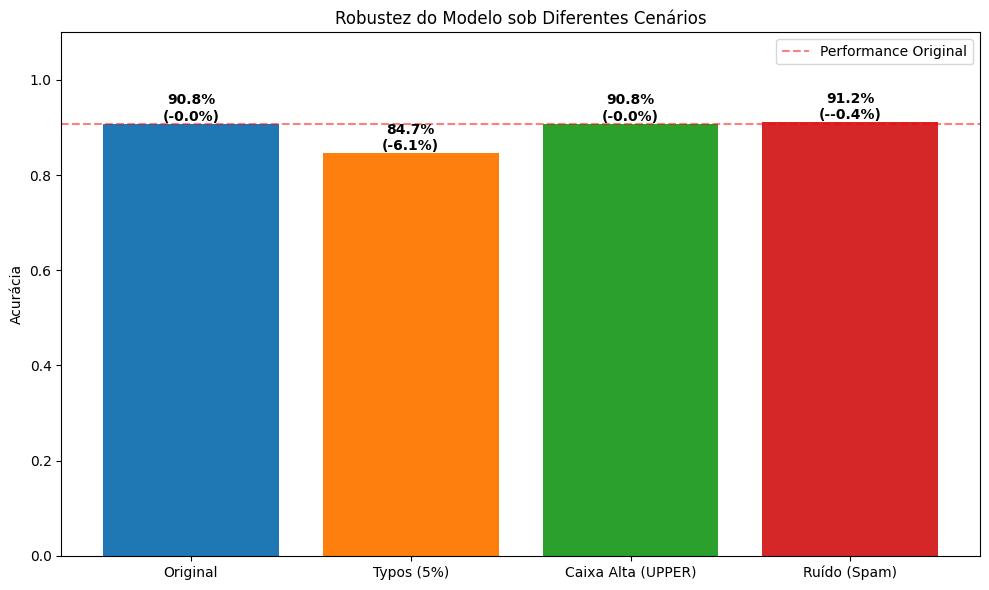

In [ ]:
# Visualização da Robustez
names = list(results_robustness.keys())
values = list(results_robustness.values())

# Calcular queda percentual em relação ao Original
original_acc = results_robustness["Original"]
drops = [(original_acc - v) * 100 for v in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

plt.ylim(0, 1.1)
plt.title("Robustez do Modelo sob Diferentes Cenários")
plt.ylabel("Acurácia")
plt.axhline(y=original_acc, color='r', linestyle='--', alpha=0.5, label='Performance Original')

# Adicionar labels nas barras
for bar, drop in zip(bars, drops):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1%}\n(-{drop:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

##Vulnerabilidade a Typos (-6.1%)
O modelo sofreu a maior queda de desempenho neste cenário. Isso ocorre devido à natureza do tokenizador do BERT (WordPiece). Palavras com erros de digitação (ex: "amazing" $\rightarrow$ "amzaing") não são reconhecidas como tokens inteiros e são quebradas em sub-palavras sem sentido semântico claro para o modelo. Isso dilui a informação de sentimento, levando a erros de classificação.

Impacto: Moderado. Indica que o modelo pode precisar de um corretor ortográfico prévio em produção.

## Robustez a Caixa Alta (0.0%)
O modelo manteve exatamente a mesma acurácia. Isso confirma a eficácia do uso do checkpoint distilbert-base-uncased. O tokenizador normaliza automaticamente todo o texto para minúsculo antes da inferência, tornando o modelo imune a variações de case.
##Estabilidade com Ruído/Spam (+0.4%)
Surpreendentemente, a acurácia variou positivamente (dentro da margem de erro estatístico). Isso demonstra que o mecanismo de Self-Attention do Transformer conseguiu atribuir pesos baixos (ignorar) aos tokens de spam inseridos no final das frases, focando corretamente nas palavras-chave de sentimento que apareceram no início ou meio do texto.

## 15) Avaliação de Interpretabilidade

In [ ]:
model_path = "./imdb_model"

In [ ]:
!pip install -q shap

In [ ]:
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:

import shap
import torch
from transformers import pipeline

# Verificação de segurança
if 'loaded_model' not in globals() or 'loaded_tokenizer' not in globals():
    raise ValueError("O modelo 'loaded_model' não foi encontrado. Por favor, re-execute o Passo 14.")

# 1. Configurar o Pipeline
device_id = 0 if torch.cuda.is_available() else -1

print("Configurando pipeline SHAP...")
# Adicionamos truncation=True aqui para garantir, embora o SHAP precise do texto cru
clf_pipeline = pipeline(
    "text-classification",
    model=loaded_model,
    tokenizer=loaded_tokenizer,
    device=device_id,
    top_k=None,
    truncation=True,    # Força o pipeline a truncar se necessário internamente
    max_length=512
)

# 2. Inicializar o Explainer
explainer = shap.Explainer(clf_pipeline)

# 3. Selecionar e TRUNCAR Exemplos
indices_to_explain = [0, 10, 25, 50]

# Função auxiliar para garantir que o texto cabe no modelo (limite de 512 tokens)
def get_safe_text(index):
    text = test_clean[index]["text"]
    # Tokeniza, corta o excesso e destokeniza de volta para texto
    # Usamos 500 para deixar uma margem de segurança para tokens especiais [CLS] e [SEP]
    tokens = loaded_tokenizer.encode(text, truncation=True, max_length=500)
    return loaded_tokenizer.decode(tokens, skip_special_tokens=True)

examples_to_explain = [get_safe_text(i) for i in indices_to_explain]

print(f"Calculando SHAP para {len(examples_to_explain)} exemplos truncados...")
# Agora não deve dar erro de tamanho
shap_values = explainer(examples_to_explain)

# 4. Visualização
print("\n=== Visualização de Importância de Palavras (SHAP) ===")
print("Vermelho: Empurra para POSITIVO | Azul: Empurra para NEGATIVO")
shap.plots.text(shap_values)

Device set to use cuda:0


Configurando pipeline SHAP...
Calculando SHAP para 4 exemplos truncados...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:16<00:03,  3.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [00:25<00:00,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [00:35,  8.87s/it]



=== Visualização de Importância de Palavras (SHAP) ===
Vermelho: Empurra para POSITIVO | Azul: Empurra para NEGATIVO


## 16) Ataques Adversários

Nesta seção avaliamos a vulnerabilidade do modelo a ataques adversários em PLN.
Diferente dos testes de robustez (ruído, typos e caixa alta), aqui criamos
entradas modificadas **intencionalmente** para tentar induzir o modelo a errar,
com pequenas alterações no texto.

O foco é responder:

- O modelo muda de decisão com perturbações bem pequenas?
- Qual a taxa de exemplos cuja predição muda após o ataque?
- Esses ataques são realistas do ponto de vista semântico?


In [20]:
import numpy as np
from datasets import Dataset

print("=== Ataques Adversários em IMDb ===")

# 1) Predições originais no subset usado em robustez
print("Calculando predições originais...")
orig_tok = test_subset.map(tokenize_for_test, batched=True, remove_columns=["text"])
orig_preds_out = robustness_trainer.predict(orig_tok)
y_true = orig_preds_out.label_ids
y_pred_orig = orig_preds_out.predictions.argmax(axis=1)
acc_orig = (y_pred_orig == y_true).mean()
print(f"Acurácia original no subset: {acc_orig:.4f}")

# 2) Definição de ataques adversários

def adv_injection_opposite_sentiment(example):
    """
    Ataque 1: injetar uma frase curta com sentimento oposto ao rótulo.
    A ideia é criar conflito no texto, tentando confundir o modelo.
    """
    text = example["text"]
    label = example["label"]

    if label == 1:  # review positiva
        suffix = " However, some people might say this movie is terrible and absolutely awful."
    else:  # review negativa
        suffix = " However, some people might say this movie is excellent and absolutely wonderful."

    example["text"] = text + " " + suffix
    return example

# Ataque 2: inserção de gatilho neutro com palavras carregadas
def adv_trigger_neutral(example):
    """
    Ataque 2: adicionar uma frase aparentemente neutra, mas com palavras fortes
    de sentimento, sem alterar diretamente a opinião original do autor.
    """
    text = example["text"]
    trigger = (
        " This sentence is only for analysis and should not change the real opinion, "
        "but it mentions that the movie is great, fantastic and wonderful."
    )
    example["text"] = text + " " + trigger
    return example

attacks = {
    "OppositeSentimentInjection": adv_injection_opposite_sentiment,
    "NeutralTriggerWithSentimentWords": adv_trigger_neutral,
}

results_adv = {}

for attack_name, attack_fn in attacks.items():
    print(f"\n=== Rodando ataque: {attack_name} ===")

    # 3) Gerar dataset adversarial
    adv_ds = test_subset.map(attack_fn)

    # 4) Tokenizar e predizer
    adv_tok = adv_ds.map(tokenize_for_test, batched=True, remove_columns=["text"])
    adv_preds_out = robustness_trainer.predict(adv_tok)
    y_pred_adv = adv_preds_out.predictions.argmax(axis=1)

    # 5) Métricas: acurácia e taxa de flip de predição
    acc_adv = (y_pred_adv == y_true).mean()
    flip_rate = (y_pred_adv != y_pred_orig).mean()

    results_adv[attack_name] = {
        "accuracy": float(acc_adv),
        "flip_rate": float(flip_rate),
    }

    print(f"Acurácia sob ataque    : {acc_adv:.4f}")
    print(f"Queda de acurácia      : {acc_adv - acc_orig:+.4f}")
    print(f"Taxa de mudança de rótulo (flip rate): {flip_rate:.2%}")

print("\nResumo ataques adversários:")
for name, stats in results_adv.items():
    print(
        f"{name:<35} | acc={stats['accuracy']:.4f} | flip={stats['flip_rate']:.2%}"
    )


=== Ataques Adversários em IMDb ===
Calculando predições originais...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Acurácia original no subset: 0.9080

=== Rodando ataque: OppositeSentimentInjection ===


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Acurácia sob ataque    : 0.8040
Queda de acurácia      : -0.1040
Taxa de mudança de rótulo (flip rate): 10.40%

=== Rodando ataque: NeutralTriggerWithSentimentWords ===


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Acurácia sob ataque    : 0.8880
Queda de acurácia      : -0.0200
Taxa de mudança de rótulo (flip rate): 4.80%

Resumo ataques adversários:
OppositeSentimentInjection          | acc=0.8040 | flip=10.40%
NeutralTriggerWithSentimentWords    | acc=0.8880 | flip=4.80%


### Ataques Adversariais

Os ataques adversariais mostram como pequenas alterações intencionais no texto podem afetar significativamente o comportamento do modelo.

No **Ataque 1 (Injeção de Sentimento Oposto)**, a acurácia caiu de **90,8% para 80,4%**, com **10,4%** das previsões mudando de rótulo. Isso ocorre porque o modelo dá muito peso a palavras de forte polaridade emocional; quando adicionamos uma frase com sentimento oposto ao original, ele se deixa influenciar por esses novos tokens, mesmo que o conteúdo principal da review continue igual.

No **Ataque 2 (Trigger Neutro com Palavras Positivas)**, a queda foi menor (**88,8% de acurácia**, flip rate de **4,8%**), mas ainda mostra que o modelo reage a pequenas inserções de termos carregados, mesmo em frases que não alteram o contexto real.

Esses resultados indicam que o modelo é **vulnerável a manipulações sutis**, especialmente quando envolvem palavras emocionalmente fortes, reforçando a importância de técnicas de robustez e treinamento adversarial em aplicações reais.
